In [1]:
using LinearAlgebra, SparseArrays

using ForwardDiff
using NLsolve, LineSearches

using BenchmarkTools

using Plots
using LaTeXStrings

using gmsh

# Define Permeability
The permeability is extracted from the datasheet of the core material (3C92) and fitted to an analytical expression.

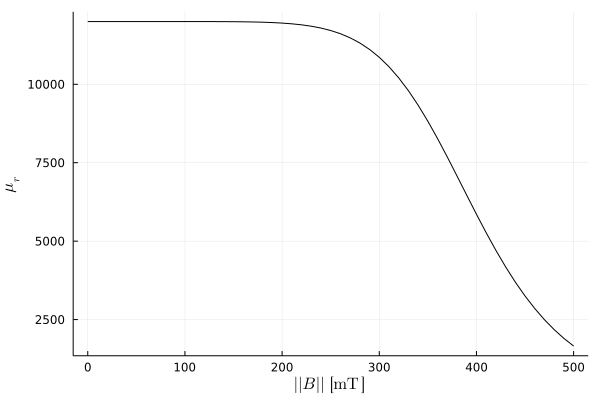

In [2]:
# Permeability function
bh_a = 1 / 12000; 
bh_b = 4;
bh_c = 7.5;
mu0 = 4e-7 * pi;
fmur_core(B) = 1 / (bh_a + (1 - bh_a) * B^(2*bh_b) / (B^(2*bh_b) + bh_c));

#a = 152.9e-3;
#b = 0.1071;
#fmur_core(B) = (b * max(B, 1e-3)) / (mu0 * sinh(max(B, 1e-3) / a));

B = Vector(0.:0.01:0.5);
plot(B * 1e3, fmur_core.(B), color = :black, xlabel = L"||B||\,\mathrm{[mT]}", ylabel = L"\mu_r", legend = false)

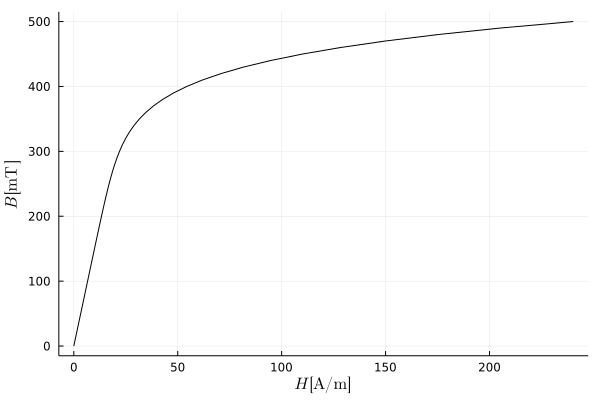

In [3]:
plot(B ./ (mu0 * fmur_core.(B)), B * 1e3, color = :black, xlabel = L"H\,\mathrm{[A/m]}", ylabel = L"B\,\mathrm{[mT]}", legend = false)

# Define Geometry

In [4]:
gmsh.finalize();
gmsh.initialize();

In [5]:
gmsh.open("geo/coil_geo.msh")

# Retrieve nodes from gmsh and sort in order of x-coords
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
xnode = node_coord[1:3:end];
p = sortperm(xnode);
x = xnode[p];
nids = node_ids[p];

Info    : Reading 'geo/coil_geo.msh'...
Info    : 15 entities
Info    : 114 nodes
Info    : 115 elements
Info    : Done reading 'geo/coil_geo.msh'


In [6]:
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(1)
nelements = length(element_ids[1])

ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 2)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 3)
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 4)
e_group = zeros(1,nelements)

for element_id in 1:nelements
    node1_id = element_connectivity[1][2*(element_id-1)+1]
    node2_id = element_connectivity[1][2*(element_id-1)+2]

    G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1]) # Air
    G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1]) # Core
    G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1]) # Coil left
    G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1]) # Coil right
    
    if G1 == 2
        e_group[element_id] = 1;
    elseif G2 == 2
        e_group[element_id] = 2;
    elseif G3 == 2
        e_group[element_id] = 3;
    elseif G4 == 2
        e_group[element_id] = 4;
    end
end

# Linear Elements

In [7]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

In [8]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
N = length(x);
points = collect( [x[i], x[i+1]] for i in 1:N-1) 
edges  = collect( [i, i+1] for i in 1:N-1); 

In [9]:
function allocate_matrices(datatype::DataType)
    A = spzeros(datatype, N, N)
    f = zeros(datatype, N)
    
    for i=1:length(edges) 
        Aloc = [1 -1; -1 1];
        A[edges[i], edges[i]] += Aloc;
    end

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,:]   = zeros(N);  A[1,1]     = 1;      f[1]   = 0;
    A[end,:] = zeros(N);  A[end,end] = 1;      f[end]   = 0;
    
    fill!(A.nzval, zero(datatype))
    
    return A, f
end

allocate_matrices (generic function with 1 method)

In [10]:
function assemble_matrices!(A::SparseMatrixCSC, f::Vector, u::Vector)
    #..Initialize global matrix and right-hand side value 
    fill!(A.nzval, 0)
    fill!(f, 0)
    
    B = abs.(diff(u) ./ diff(x));
    fnu_elem = map(fnu, e_group, B);
    
    Ae = zeros(eltype(u), 2, 2)
    fe = zeros(eltype(u), 2)
    
    ftempl = [1; 1];
    Atempl = [1 -1; -1 1];

    #..Perform loop over elements and assemble global matrix and vector 
    for i=1:length(edges) 
        xl, xr = points[i,:][1]
        h = xr - xl;

        fe[:] = h/2 * ftempl * fsource_elem[i];
        Ae[:] = fnu_elem[i] / h * Atempl;
        
        f[edges[i]] += fe;
        A[edges[i], edges[i]] += Ae;
    end

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,:]   .= 0;  A[1,1]     = 1;      f[1]   = 0;
    A[end,:] .= 0;  A[end,end] = 1;      f[end]   = 0;
    
    return A, f;
end

function res!(R, u)
    assemble_matrices!(A, f, u);
    R[:] = A * u - f;
end

res! (generic function with 1 method)

In [11]:
A, f = allocate_matrices(Float64)
assemble_matrices!(A, f, zeros(size(x)))
ulin = A \ f;

results = nlsolve(res!, ulin, autodiff = :finite, show_trace = :true)
u = results.zero;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.030969e+06              NaN
     1     3.169013e+02     4.155030e-01
     2     3.030969e+06     2.576150e-21
     3     3.030969e+06     0.000000e+00
     4     1.455604e+06     4.235165e-22
     5     6.497099e+04     0.000000e+00
     6     1.293992e+02     5.193790e-02
     7     2.330027e+01     3.312023e-03
     8     9.604978e-01     5.751808e-04
     9     3.059389e-03     2.549244e-05
    10     4.279677e-06     8.183144e-08
    11     6.165489e-09     1.143415e-10


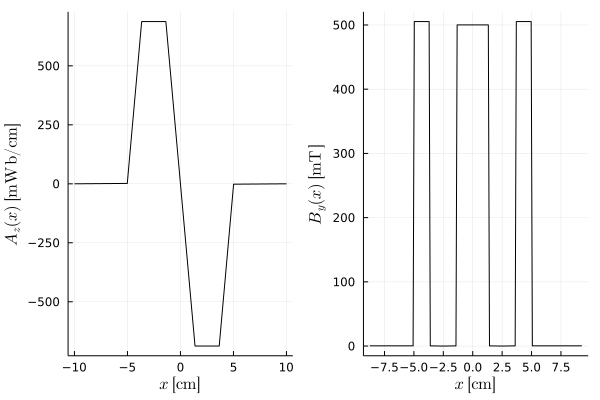

In [12]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = diff(u) ./ diff(x);

# Plot
p1 = plot(x * 1e2, u * 1e5, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"A_z(x)\ \mathrm{[mWb/cm]}", color = :black, lw = 1, legend = false);
p2 = plot(xmid * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false);

plot(p1, p2)

# Linear Elements & Eddy Currents

In [7]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

sigma_core = 0.2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

f     = 10e6;
omega = 2*pi*f;

In [8]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
N = length(x);
points = collect( [x[i], x[i+1]] for i in 1:N-1) 
edges  = collect( [i, i+1] for i in 1:N-1); 

function calc_fnu(u, x)
    B = abs.(diff(u) ./ diff(x));
    fnu_elem = map(fnu, e_group, B);
    
    return fnu_elem;
end

function assemble_matrices(u::Vector, fsource_elem, fsigma_elem)
    # Initialize vectors for sparse matrix construction
    I = zeros(Int64, 4*length(edges))
    J = similar(I);
    V = zeros(Complex{Float64}, length(I));
    
    # Initialize right-hand side vector
    f = zeros(Complex{Float64}, N);
    
    fnu_elem = calc_fnu(u, x)
    
    #..Perform loop over elements and assemble global matrix and vector 
    for (i, nodes) = enumerate(edges)
        idx = 4*(i-1) + 1 : 4*i;
        h   = points[i][2] - points[i][1];
        
        #
        f[nodes] += fsource_elem[i] * h / 2 * [1; 1];
        
        # Matrix contribution
        I[idx] = nodes[[1, 2, 1, 2]];
        J[idx] = nodes[[1, 1, 2, 2]];
        V[idx] = fnu_elem[i] / h * [1 -1 -1 1] + 1im * omega * fsigma_elem[i] * h * [1/3 1/6 1/6 1/3];
    end
    
    A = sparse(I, J, V)
    
    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,:]   = zeros(N);  A[1,1]     = 1;      f[1]   = 0;
    A[end,:] = zeros(N);  A[end,end] = 1;      f[end] = 0;
    
    return A, f
end

assemble_matrices (generic function with 1 method)

In [ ]:
function res!(R, u)
    A, f = assemble_matrices(u, fsource_elem, fsigma_elem);
    R[:] = A * u - f;
end

In [82]:
@benchmark assemble_matrices(ulin, fsource_elem, fsigma_elem)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  187.100 μs …   6.650 ms  ┊ GC (min … max):  0.00% … 95.63%
 Time  (median):     194.000 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   233.256 μs ± 351.729 μs  ┊ GC (mean ± σ):  11.71% ±  7.44%

  ▆█▇▆▅▄▂▂▁  ▁▁  ▁▂▁▁▁                       ▁▃▃▁               ▂
  █████████████████████████▇▇▆▆▆▆▅▅▅▅▅▃▄▄▃▄▅▅████▇▇▇▁▅▅▃▅▃▅▄▄▄▆ █
  187 μs        Histogram: log(frequency) by time        371 μs <

 Memory estimate: 278.16 KiB, allocs estimate: 4913.

In [84]:
function nonlinsolve(fsource_elem, fsigma_elem, N)
    A, f = assemble_matrices(zeros(N), fsource_elem, fsigma_elem)
    u = A \ f;

    du = 1e6;
    Niter = 1;

    tol = 1e-6;
    Nmax = 100;
    
    uhist = zeros(N);
    alpha = 0.8;
    
    while (du > tol) && (Niter < Nmax)
        uprev = u;
        #uhist = (uhist * Niter + u) / (Niter + 1);
        uhist = uhist * alpha + u * (1 - alpha);    # Provide some damping to prevent oscillation between two solutions

        A, f = assemble_matrices(uhist, fsource_elem, fsigma_elem);
        u = A \ f;

        du = norm(u - uprev);
        Niter += 1;
        print("#$Niter: $du\n")
    end
    
    return u;
end

nonlinsolve (generic function with 1 method)

In [85]:
u = nonlinsolve(fsource_elem, fsigma_elem, N);

#2: 0.029661208344445814
#3: 0.009967240153481341
#4: 0.0034155707049186154
#5: 0.001389310950785404
#6: 0.0008736891710000928
#7: 0.0005211396659838922
#8: 0.0003413923429212086
#9: 0.0002117091860884285
#10: 0.00014554990223738455
#11: 9.009098750592919e-5
#12: 6.589282642436216e-5
#13: 4.148442916722004e-5
#14: 2.9532289060550142e-5
#15: 1.877599745867397e-5
#16: 1.3651049054398125e-5
#17: 9.239199323241703e-6
#18: 6.95962787390226e-6
#19: 5.0598434733420114e-6
#20: 3.943394129953532e-6
#21: 3.0414278223072287e-6
#22: 2.4237597069698986e-6
#23: 1.9226848172621217e-6
#24: 1.5397657101542201e-6
#25: 1.227653953752614e-6
#26: 9.790127372206673e-7


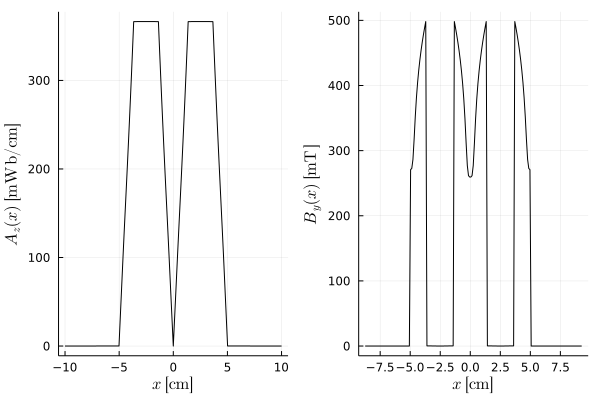

In [86]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = diff(u) ./ diff(x);
Jeddy = 1im * omega * Transpose(fsigma_elem) .* (u[1:end-1] + u[2:end]) / 2;

# Plot
p1 = plot(x * 1e2, norm.(u) * 1e5, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"A_z(x)\ \mathrm{[mWb/cm]}", color = :black, lw = 1, legend = false);
p2 = plot(xmid * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false);

plot(p1, p2)

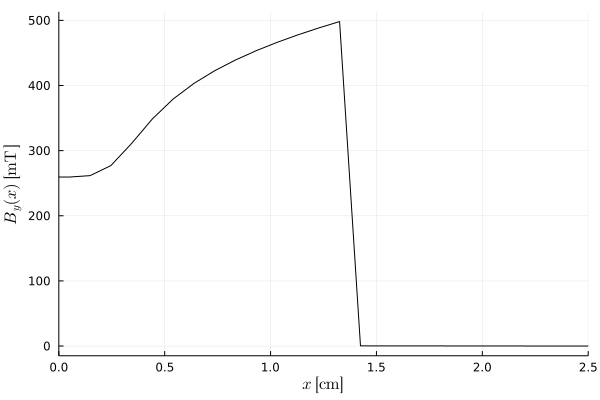

In [87]:
plot(xmid * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))

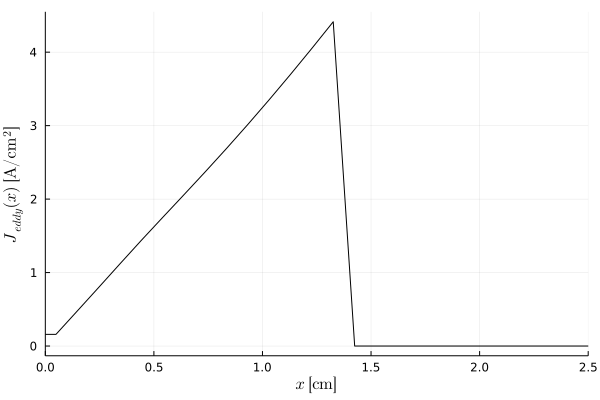

In [71]:
plot(xmid * 1e2, norm.(Jeddy) * 1e-4, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"J_{eddy}(x)\ \mathrm{[A/cm^2]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))

In [ ]:
## Code for NLsolve
# This does not work very well because the finite-difference autodiff cannot reliabily calculate the Jacobian
# The Jacobian is not smooth enough in the time-harmonic case...

A, f = assemble_matrices(zeros(N), fsource_elem, fsigma_elem)
ulin = A \ f;

initial_F = similar(ulin)
initial_J = similar(A)
df = OnceDifferentiable(res!, ulin, initial_F, initial_J)
@time results = nlsolve(df, ulin, method = :newton, linesearch = BackTracking(order = 2))
u = results.zero;

print("Converged: ", results.f_converged, " (residual norm: ", results.residual_norm, ", evaluations: ", df.f_calls, "/", df.df_calls, ")\n")

# Quadratic Elements & Eddy Currents

In [88]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

sigma_core = 0.2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

f     = 10e6;
omega = 2*pi*f;

In [114]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
Na = 2 * length(x) - 1;
points = collect( [x[i], 0.5*(x[i] + x[i+1]), x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1, i+2] for i in 1:2:Na-1); 

X = collect([points[i][1], points[i][2]] for i in 1:length(points))
X = reduce(vcat, X);
X = vcat(X, x[end]);

function calc_fnu(u, x)
    #B = abs.(diff(u) ./ diff(x));
    B = zeros(Na);
    Emat = 2 * [2, -4, 2] * [0 0.5 1] .+ [-3, 4, -1];
    for i=1:length(edges) 
        xl, xm, xr = points[i,:][1];
        ul, um, ur = u[edges[i]];

        dux  = [ul um ur] * Emat / (xr - xl);
        B[i] = norm.(dux[2]);
    end
    
    fnu_elem = map(fnu, e_group, B);
    
    return fnu_elem;
end

function assemble_matrices(u::Vector, fsource_elem, fsigma_elem)
    # Initialize vectors for sparse matrix construction
    I = zeros(Int64, 9*length(edges))
    J = similar(I);
    V = zeros(Complex{Float64}, length(I));
    
    # Initialize right-hand side vector
    f = zeros(Complex{Float64}, Na);
    
    fnu_elem = calc_fnu(u, X)
    
    idxI = [1, 2, 3, 1, 2, 3, 1, 2, 3];
    idxJ = [1, 1, 1, 2, 2, 2, 3, 3, 3];
    
    #..Perform loop over elements and assemble global matrix and vector 
    for (i, nodes) = enumerate(edges)
        idx = 9*(i-1) + 1 : 9*i;
        h   = points[i][2] - points[i][1];
        
        #
        f[nodes] += fsource_elem[i] * h / 6 * [1; 4; 1];
        
        # Matrix contribution
        I[idx] = nodes[idxI];
        J[idx] = nodes[idxJ];
        V[idx] = fnu_elem[i] / (3*h) * [7 -8 1 -8 16 -8 1 -8 7] + 1im * omega * fsigma_elem[i] * h / 30 * [4 2 -1 2 16 2 -1 2 4];
    end
    
    A = sparse(I, J, V)
    
    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,:]   .= 0;  A[1,1]     = 1;      f[1]   = 0;
    A[end,:] .= 0;  A[end,end] = 1;      f[end] = 0;
    
    return A, f
end

assemble_matrices (generic function with 1 method)

In [115]:
function res!(R, u)
    A, f = assemble_matrices(u, fsource_elem, fsigma_elem);
    R[:] = A * u - f;
end

res! (generic function with 1 method)

In [134]:
function nonlinsolve(fsource_elem, fsigma_elem, N, alpha = 0.8)
    A, f = assemble_matrices(zeros(N), fsource_elem, fsigma_elem)
    u = A \ f;

    du = 1e6;
    Niter = 1;

    tol = 1e-9;
    Nmax = 100;
    
    uhist = zeros(N);
    
    while (du > tol) && (Niter < Nmax)
        uprev = u;
        #uhist = (uhist * Niter + u) / (Niter + 1);
        uhist = uhist * alpha + u * (1 - alpha);    # Provide some damping to prevent oscillation between two solutions

        A, f = assemble_matrices(uhist, fsource_elem, fsigma_elem);
        u = A \ f;

        du = norm(u - uprev);
        Niter += 1;
        print("#$Niter: $du\n")
    end
    
    return u;
end

nonlinsolve (generic function with 2 methods)

In [117]:
u = nonlinsolve(fsource_elem, fsigma_elem, Na, 0.7);

#2: 0.00033527530932391745
#3: 0.007958177325888577
#4: 0.0019098292060885245
#5: 0.0010704322235489008
#6: 0.0005139759089327049
#7: 0.0003303165875850116
#8: 0.00021373482017718754
#9: 0.00011206931371862924
#10: 8.780815471520695e-5
#11: 3.8326130400572114e-5
#12: 3.5554109697555515e-5
#13: 1.3427875695390249e-5
#14: 1.4394523351167404e-5
#15: 4.959060799973473e-6
#16: 5.880488249279023e-6
#17: 1.9801923747256927e-6
#18: 2.4377207248911326e-6
#19: 8.582404408813711e-7
#20: 1.0284057783554523e-6
#21: 3.949978986528372e-7
#22: 4.41783926054734e-7
#23: 1.8763129165292028e-7
#24: 1.930377098126624e-7
#25: 9.018398120833607e-8
#26: 8.561621778101996e-8
#27: 4.3419516650208006e-8
#28: 3.844917826258858e-8
#29: 2.0854384873356898e-8
#30: 1.7442036964835275e-8
#31: 9.978960973256601e-9
#32: 7.975747842806498e-9
#33: 4.757523984787911e-9
#34: 3.669448691748924e-9
#35: 2.2613489138994747e-9
#36: 1.6965863108892664e-9
#37: 1.0716698875891606e-9
#38: 7.869553325409751e-10


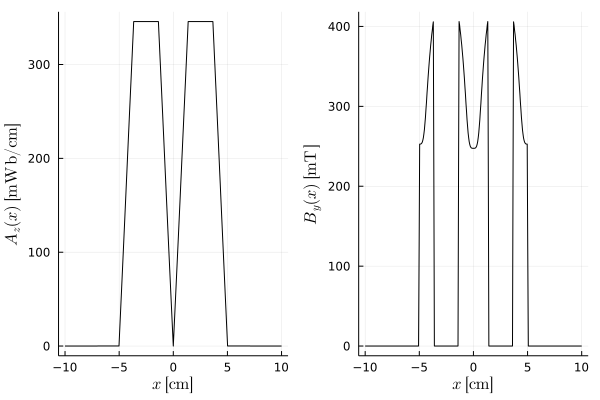

In [121]:
# Post-processing
function process(u)
    ux    = zeros(Complex{Float64}, Na);
    Jeddy = zeros(Complex{Float64}, Na);

    Emat = 2 * [2, -4, 2] * [0 0.5 1] .+ [-3, 4, -1];
    for i=1:length(edges) 
        xl, xm, xr = points[i,:][1];
        ul, um, ur = u[edges[i]];

        dux = [ul um ur] * Emat / (xr - xl);

        ux[edges[i]] += [dux[1]/2; dux[2]; dux[3]/2];

        if(i < N-1 && fsigma_elem[i+1] <= 0)
            Jeddy[edges[i]] += 1im * omega * fsigma_elem[i] * [ul/2 um ur]';
        elseif(i > 2 && fsigma_elem[i-1] <= 0)
            Jeddy[edges[i]] += 1im * omega * fsigma_elem[i] * [ul um ur/2]';
        else
            Jeddy[edges[i]] += 1im * omega * fsigma_elem[i] * [ul/2 um ur/2]';
        end
    end
    
    return ux, Jeddy;
end

ux, Jeddy = process(u);
    
# Plot
p1 = plot(X * 1e2, norm.(u) * 1e5, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"A_z(x)\ \mathrm{[mWb/cm]}", color = :black, lw = 1, legend = false);
p2 = plot(X * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false);

plot(p1, p2)

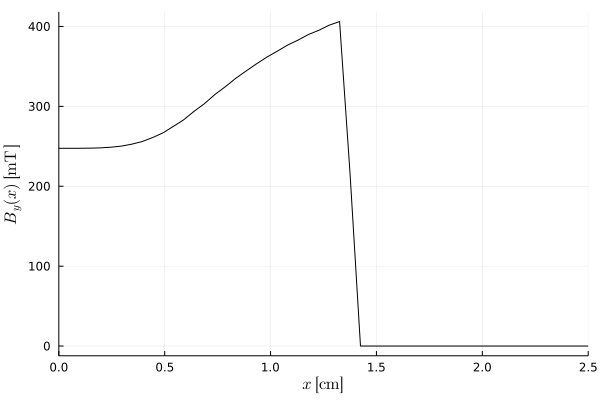

In [122]:
plot(X * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))

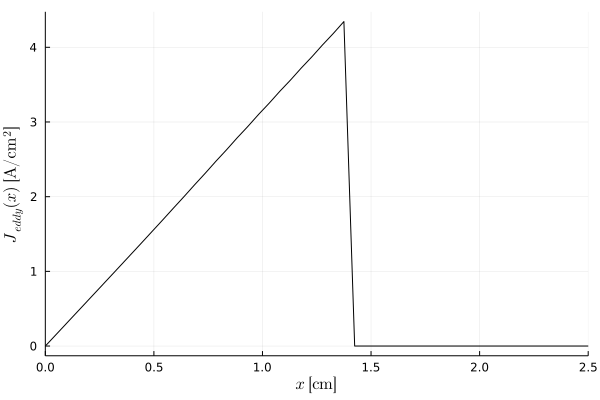

In [123]:
plot(X * 1e2, norm.(Jeddy) * 1e-4, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"J_{eddy}(x)\ \mathrm{[A/cm^2]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))

In [ ]:
## Code for NLsolve
# This does not work very well because the finite-difference autodiff cannot reliabily calculate the Jacobian
# The Jacobian is not smooth enough in the time-harmonic case...

A, f = assemble_matrices(zeros(Na), fsource_elem, fsigma_elem)
ulin = A \ f;

initial_F = similar(ulin)
initial_J = similar(A)
df = OnceDifferentiable(res!, ulin, initial_F, initial_J)
@time results = nlsolve(df, ulin, method = :newton, linesearch = BackTracking(order = 2))
u = results.zero;

print("Converged: ", results.f_converged, " (residual norm: ", results.residual_norm, ", evaluations: ", df.f_calls, "/", df.df_calls, ")\n")

# Case 1: Linear
If the excitation current is low enough, the core will stay in the linear region. This requires only two solver steps to find the solution, due to the linearity.

In [135]:
#..Set the source function 
J = 2.2e4 / 10;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

sigma_core = 0.2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

f     = 10e6;
omega = 2*pi*f;

In [137]:
u = nonlinsolve(fsource_elem, fsigma_elem, Na, 0.9);

#2: 1.4179997410611755e-15


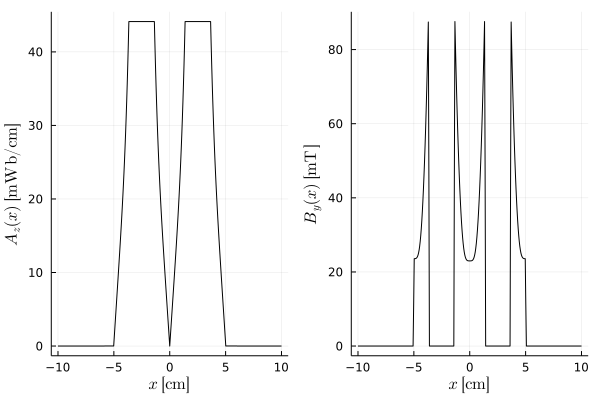

In [138]:
ux, Jeddy = process(u);
    
# Plot
p1 = plot(X * 1e2, norm.(u) * 1e5, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"A_z(x)\ \mathrm{[mWb/cm]}", color = :black, lw = 1, legend = false);
p2 = plot(X * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false);

plot(p1, p2)

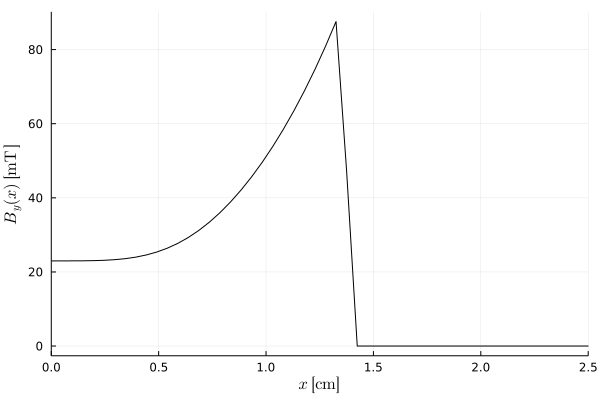

In [141]:
plot(X * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))

# Case 2: Non-linear

In [152]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

sigma_core = 0.2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

f     = 10e6;
omega = 2*pi*f;

In [153]:
u = nonlinsolve(fsource_elem, fsigma_elem, Na, 0.7);

#2: 0.00033527530932391745
#3: 0.007958177325888577
#4: 0.0019098292060885245
#5: 0.0010704322235489008
#6: 0.0005139759089327049
#7: 0.0003303165875850116
#8: 0.00021373482017718754
#9: 0.00011206931371862924
#10: 8.780815471520695e-5
#11: 3.8326130400572114e-5
#12: 3.5554109697555515e-5
#13: 1.3427875695390249e-5
#14: 1.4394523351167404e-5
#15: 4.959060799973473e-6
#16: 5.880488249279023e-6
#17: 1.9801923747256927e-6
#18: 2.4377207248911326e-6
#19: 8.582404408813711e-7
#20: 1.0284057783554523e-6
#21: 3.949978986528372e-7
#22: 4.41783926054734e-7
#23: 1.8763129165292028e-7
#24: 1.930377098126624e-7
#25: 9.018398120833607e-8
#26: 8.561621778101996e-8
#27: 4.3419516650208006e-8
#28: 3.844917826258858e-8
#29: 2.0854384873356898e-8
#30: 1.7442036964835275e-8
#31: 9.978960973256601e-9
#32: 7.975747842806498e-9
#33: 4.757523984787911e-9
#34: 3.669448691748924e-9
#35: 2.2613489138994747e-9
#36: 1.6965863108892664e-9
#37: 1.0716698875891606e-9
#38: 7.869553325409751e-10


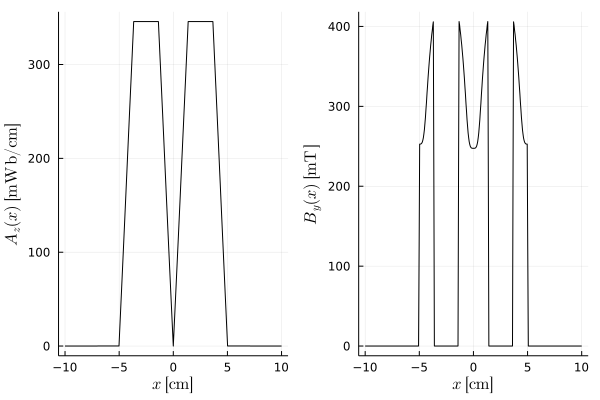

In [154]:
ux, Jeddy = process(u);
    
# Plot
p1 = plot(X * 1e2, norm.(u) * 1e5, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"A_z(x)\ \mathrm{[mWb/cm]}", color = :black, lw = 1, legend = false);
p2 = plot(X * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false);

plot(p1, p2)

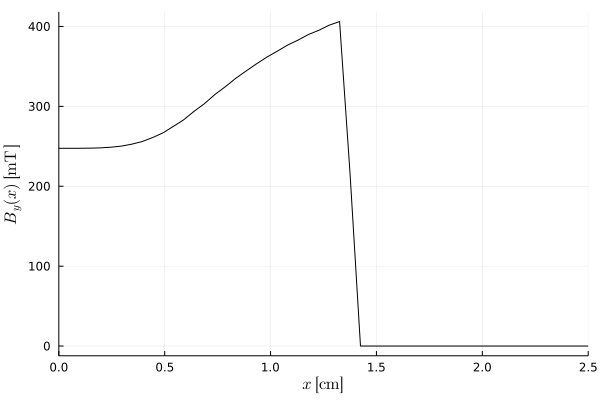

In [155]:
plot(X * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))

# Case 3: Saturation

In [156]:
#..Set the source function 
J = 2.2e4 * 5;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

sigma_core = 0.2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

f     = 10e6;
omega = 2*pi*f;

In [157]:
u = nonlinsolve(fsource_elem, fsigma_elem, Na, 0.9);

#2: 0.04025419627184641
#3: 0.07080372234707737
#4: 0.02336271800019977
#5: 0.05035736317727276
#6: 0.032411740358328646
#7: 0.006775198684930385
#8: 0.004079933283790404
#9: 0.0030893870465256473
#10: 0.002354437593187774
#11: 0.0018207047651648722
#12: 0.001428659623668723
#13: 0.0011341993370553043
#14: 0.0009084703347453561
#15: 0.0007325497823343054
#16: 0.0005936609832148543
#17: 0.00048289855081943563
#18: 0.0003938740921030444
#19: 0.00032188923861851157
#20: 0.00026341420992301024
#21: 0.00021574880216099747
#22: 0.0001767955525360259
#23: 0.00014490417124723374
#24: 0.0001187622736516417
#25: 9.731700503152693e-5
#26: 7.971772715582845e-5
#27: 6.527329387274681e-5
#28: 5.34197031719091e-5
#29: 4.369517958662599e-5
#30: 3.572074191619722e-5
#31: 2.918484304445806e-5
#32: 2.383111295896568e-5
#33: 1.9448461201284138e-5
#34: 1.5863056780357577e-5
#35: 1.293177773058666e-5
#36: 1.0536824602682317e-5
#37: 8.581293433478055e-6
#38: 6.985531858949198e-6
#39: 5.684102481191868e-6
#40

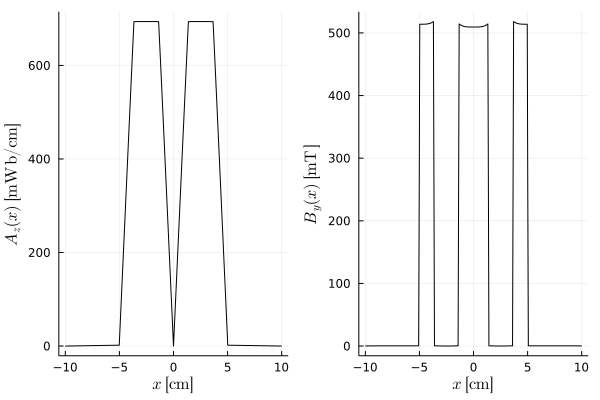

In [158]:
ux, Jeddy = process(u);
    
# Plot
p1 = plot(X * 1e2, norm.(u) * 1e5, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"A_z(x)\ \mathrm{[mWb/cm]}", color = :black, lw = 1, legend = false);
p2 = plot(X * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false);

plot(p1, p2)

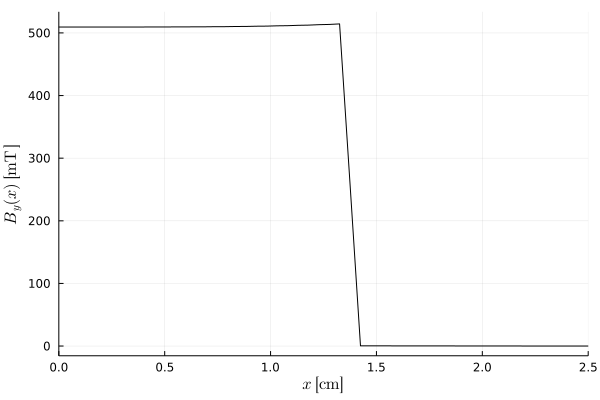

In [159]:
plot(X * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))